In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
BASE_DIR = "/Users/akshatha/GeorgakopoulosSoaresLab/g4_analysis"
SPECIES_DATA = f"{BASE_DIR}/results/species_data.csv"
G4_PATH = f"{BASE_DIR}/results/g4hunter_g4_distribution.csv"

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'    

# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}

In [15]:
# read species data
df_species = pd.read_csv(f"{BASE_DIR}/results/species_data.csv")
df_species = df_species[["Accession", "Genome Size", "GC Percentage", "Taxa", "Kingdom", "Phylum"]]
df_species = df_species.replace('na', np.nan)
df_species["GC Percentage"] = df_species["GC Percentage"].astype(float)
df_species["Genome Size"] = df_species["Genome Size"].astype(float)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)

# read g4 data
df_g4 = pd.read_csv(G4_PATH)
df_g4 = df_g4[["accession", "g4_count", "total_g4_length"]]
df_g4 = df_g4.rename(columns={"accession": "Accession"})
df_g4["g4_count"] = df_g4["g4_count"].astype(float)
df_g4["total_g4_length"] = df_g4["total_g4_length"].astype(float)
# merge with species data
df_g4 = pd.merge(df_g4, df_species, on="Accession")
df_g4["G4 Density (per Mb)"] = df_g4["g4_count"] / df_g4["Genome Size"] * 1000000
df_g4["GC Corrected G4 Density (per Mb)"] = df_g4["G4 Density (per Mb)"] / (df_g4["GC Percentage"] / 50)

# filter out metagenomes and other taxa as they are not relevant for domain level analysis
df_g4 = df_g4[df_g4["Taxa"] != "metagenomes"]
df_g4 = df_g4[df_g4["Taxa"] != "other"]

# for viruses, set kingdom as virus
df_g4.loc[df_g4["Taxa"] == "viral", "Kingdom"] = "Virus"

df_g4.head()

,Accession,g4_count,total_g4_length,Genome Size,GC Percentage,Taxa,Kingdom,Phylum,Domain,G4 Density (per Mb),GC Corrected G4 Density (per Mb)
0,GCA_000002515.1,356.0,11512.0,10689156.0,38.5,fungi,Fungi,Ascomycota,Eukaryota,33.304781,43.252962
1,GCA_000002765.3,438.0,15119.0,23292622.0,19.0,protozoa,Protista,Apicomplexa,Eukaryota,18.804238,49.484836
2,GCA_000002985.3,11196.0,406037.0,100272607.0,35.0,invertebrate,Animalia,Nematoda,Eukaryota,111.655619,159.508027
3,GCA_000006605.1,909.0,28761.0,2476822.0,61.0,bacteria,Eubacteria,Actinomycetota,Bacteria,367.002554,300.821766
4,GCA_000006645.1,765.0,23973.0,4701745.0,47.5,bacteria,Eubacteria,Pseudomonadota,Bacteria,162.705549,171.268999


In [11]:
# group by kingdom and get mean values
df_k = df_g4.groupby(["Kingdom"]).agg({
    "g4_count": "sum",
    "G4 Density (per Mb)": "mean",
    "GC Corrected G4 Density (per Mb)": "mean",
    "Accession": "count"
    }).reset_index()
df_k.columns = ["Kingdom", "Total no. of G4s", "Average G4 Density (per Mb)", "Average GC Corrected G4 Density (per Mb)", "No. of Species"]
# add new column for G4 occurences per species
df_k["G4 occurrences per species"] = df_k["Total no. of G4s"]/df_k["No. of Species"]
df_k = df_k.sort_values(by="Average G4 Density (per Mb)", ascending=False).reset_index(drop=True)
df_k.head()

,Kingdom,Total no. of G4s,Average G4 Density (per Mb),Average GC Corrected G4 Density (per Mb),No. of Species,G4 occurrences per species
0,Protista,397172.0,459.498629,411.426860,28,14184.714286
1,Animalia,58082746.0,388.532003,473.457016,79,735224.632911
2,Plantae,13627520.0,329.664289,335.753390,68,200404.705882
3,Fungi,3146845.0,297.205982,303.621406,351,8965.370370
4,Virus,593050.0,240.291546,231.121623,63658,9.316190


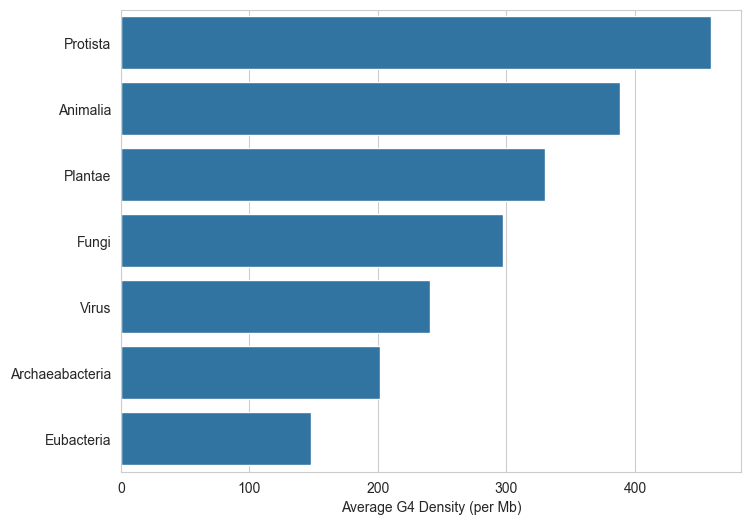

In [12]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x="Average G4 Density (per Mb)", y="Kingdom", data=df_k)
plt.ylabel("")
plt.savefig(f"{BASE_DIR}/plots/g4_density_by_kingdom_g4hunter.png", dpi=300)

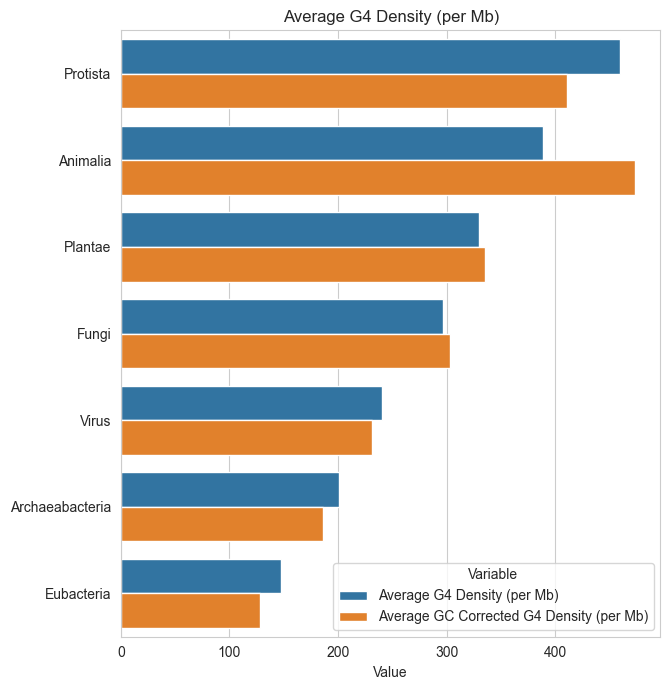

In [13]:
# bar plot for Average G4 Density (per Mb)
sns.set_style("whitegrid")
plt.figure(figsize=(7, 7))
df = pd.DataFrame({
    'Kingdom': df_k['Kingdom'],
    'Average G4 Density (per Mb)': df_k['Average G4 Density (per Mb)'],
    'Average GC Corrected G4 Density (per Mb)': df_k['Average GC Corrected G4 Density (per Mb)']
})
tidy = df.melt(id_vars='Kingdom').rename(columns=str.title)
sns.barplot(x="Value", y="Kingdom", hue='Variable', data=tidy)
plt.title("Average G4 Density (per Mb)")
plt.tight_layout()
plt.ylabel("")
plt.savefig(f"{BASE_DIR}/plots/g4_density_kingdom_gc_corrected_g4hunter.png", dpi=300)

In [18]:
# group by Phylum and get mean values
df_p = df_g4.groupby(["Phylum"]).agg({
    "Kingdom": "first",
    "g4_count": "sum",
    "G4 Density (per Mb)": "mean",
    "GC Corrected G4 Density (per Mb)": "mean",
    "Accession": "count"
    })
df_p.columns = ["Kingdom", "Total no. of G4s", "Average G4 Density (per Mb)", "Average GC Corrected G4 Density (per Mb)", "No. of Species"]
# add standard deviation for G4 Density
df_p["G4 Density (per Mb) std error"] = df_g4.groupby(["Phylum"])["G4 Density (per Mb)"].sem()
# add new column for G4 occurences per species
df_p["G4 occurrences per species"] = df_p["Total no. of G4s"]/df_p["No. of Species"]
df_p = df_p.sort_values(by="Average G4 Density (per Mb)", ascending=False)
df_p.head()

,Kingdom,Total no. of G4s,Average G4 Density (per Mb),Average GC Corrected G4 Density (per Mb),No. of Species,G4 Density (per Mb) std error,G4 occurrences per species
Phylum,,,,,,,
Deinococcota,Eubacteria,506985.0,2284.812479,1684.483250,86,158.788152,5895.174419
Candidatus Bipolaricaulota,Eubacteria,5382.0,1836.315419,1357.767971,2,462.946552,2691.000000
Chlorophyta,Plantae,555400.0,1382.025471,1077.184214,9,338.361261,61711.111111
Peploviricota,Virus,319221.0,1335.949269,1099.881793,1414,27.758073,225.757426
Euglenozoa,Protista,391136.0,1112.940111,959.126028,11,117.381673,35557.818182


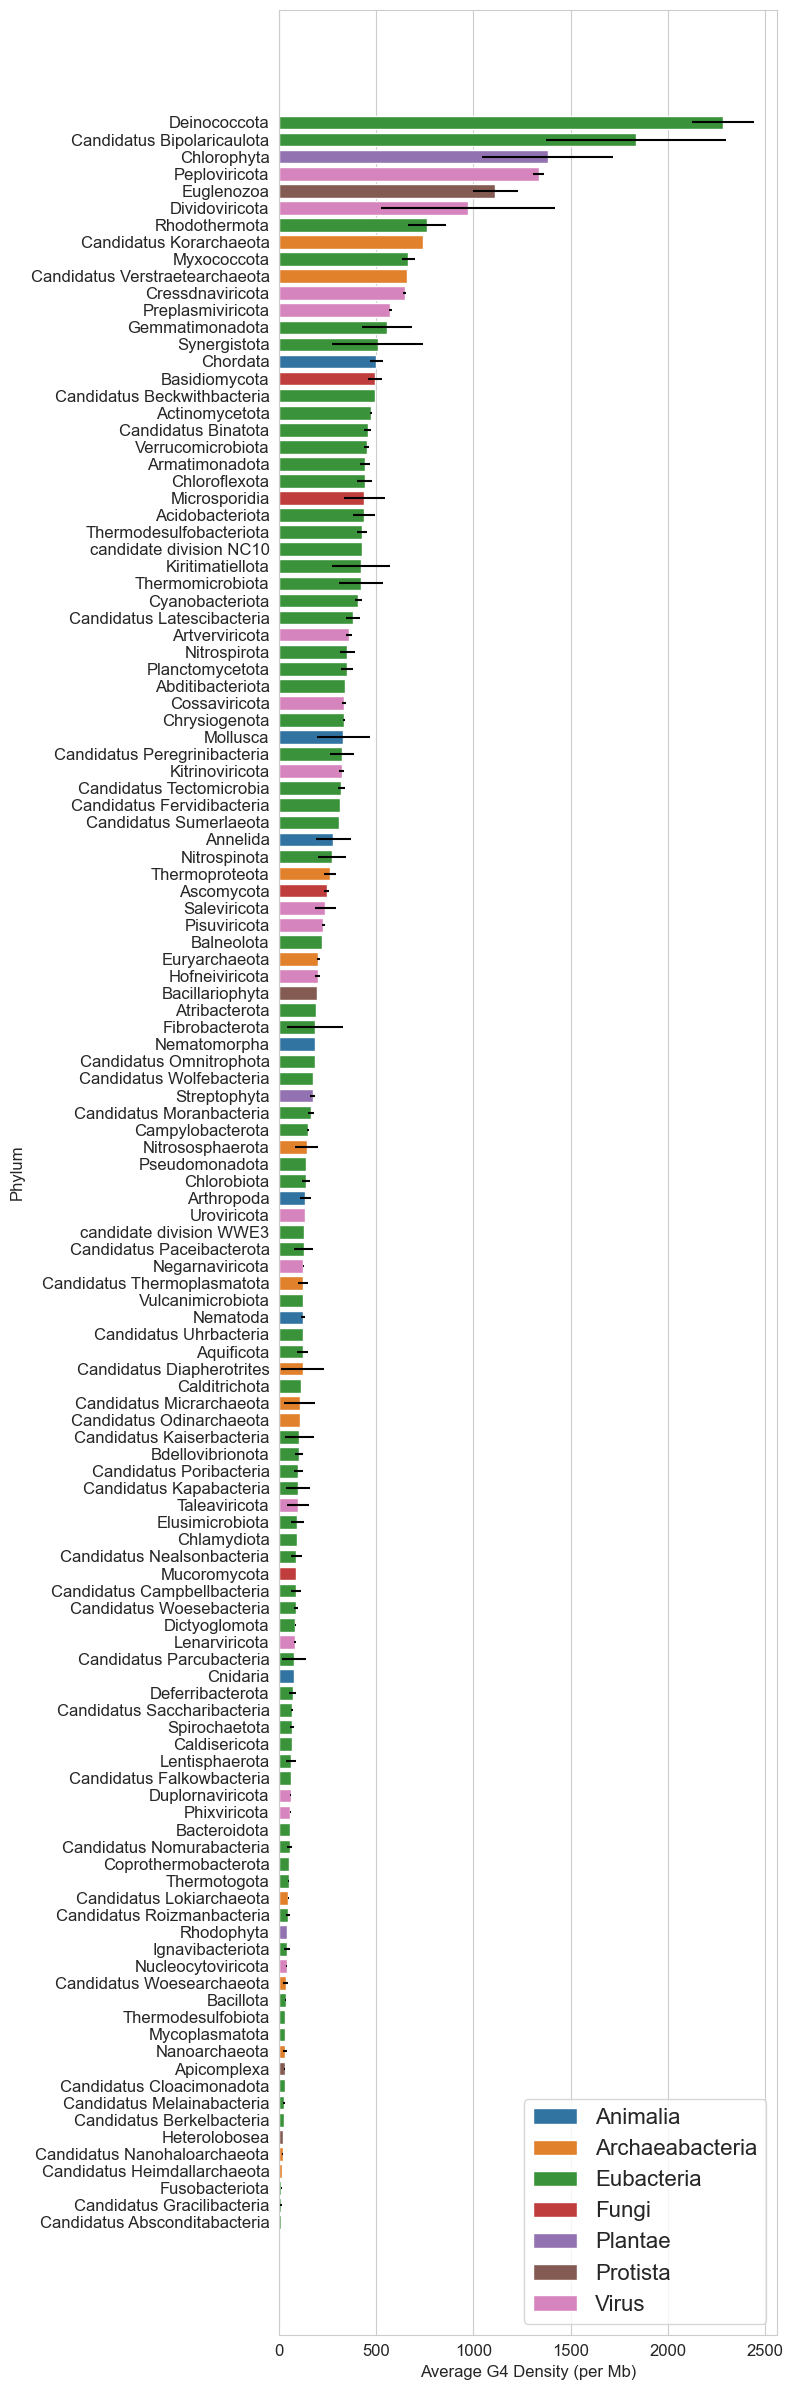

In [20]:
# have fixed order for kindoms to ensure consistent coloring in plots
kingdoms = df_p["Kingdom"].unique()
kingdoms = sorted(kingdoms)

sns.set_style("whitegrid")
plt.figure(figsize=(8, 24))
sns.barplot(
    x="Average G4 Density (per Mb)", 
    y="Phylum", 
    hue="Kingdom", 
    hue_order=kingdoms,
    data=df_p
)
# set error bars
plt.errorbar(
    x=df_p["Average G4 Density (per Mb)"], 
    y=df_p.index, 
    xerr=df_p["G4 Density (per Mb) std error"],
    fmt='none',
    c="black"
)

# formatting
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Average G4 Density (per Mb)", fontsize=12)
plt.ylabel("Phylum", fontsize=12)
plt.legend(loc="lower right", title="", fontsize=16)
plt.tight_layout() 

plt.savefig(f"{BASE_DIR}/plots/g4_density_kingdom_phylum_full_g4hunter.png")

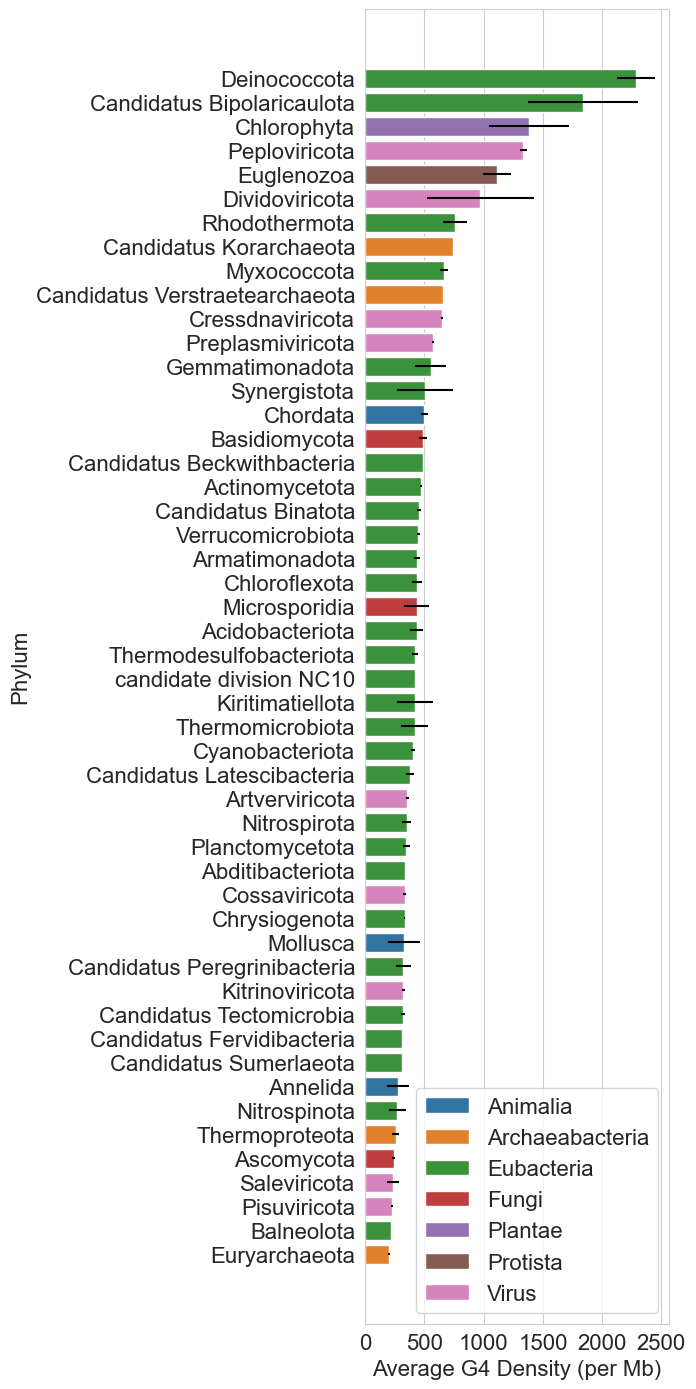

In [22]:
# get top 50 phyla
df_p = df_p[:50]

# have fixed order for kindoms to ensure consistent coloring in plots
kingdoms = df_p["Kingdom"].unique()
kingdoms = sorted(kingdoms)

sns.set_style("whitegrid")
plt.figure(figsize=(7, 14))
sns.barplot(
    x="Average G4 Density (per Mb)", 
    y="Phylum", 
    hue="Kingdom", 
    hue_order=kingdoms,
    data=df_p
)
# set error bars
plt.errorbar(
    x=df_p["Average G4 Density (per Mb)"], 
    y=df_p.index, 
    xerr=df_p["G4 Density (per Mb) std error"],
    fmt='none',
    c="black"
)

# formatting
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Average G4 Density (per Mb)", fontsize=16)
plt.ylabel("Phylum", fontsize=16)
plt.legend(loc="lower right", title="", fontsize=16)
plt.tight_layout() 

plt.savefig(f"{BASE_DIR}/plots/g4_density_kingdom_phylum_g4hunter.png")